# Reproduction d'une partie de la méthode de grasping RGB (2D)

https://arxiv.org/pdf/1412.3128.pdf
Utilise le jeu de données de Cornell, mais uniquement la partie 2D.

Une implémentation est disponible sur GitHub en license Apache: https://github.com/tnikolla/robot-grasp-detection.  
Ce code en est en partie inspiré.

## Partie I: mise en forme des données

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
def load_image( filename ) :
    """Permet de récupérer l'image sous forme d'array pour la manipuler. On utilise les fonctions de PIL."""
    img = Image.open( filename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [3]:
def process_image( filename ):
    img=load_image( filename )
    assert len(image.shape) == 3
    height = img[0]
    length = img[1]
    assert image.shape[2] == 3 
    return img, height, length

In [4]:
def process_graspbox(name):
    """_process_bboxes sur github"""
    f=open(name, 'r')
    graspbox = list(map(
        lambda coordinate: float(coordinate), f.read().strip().split()))    
    return graspbox

**Quelques explications:** ici, on cherche à transformer le fichier décrivant les grasps en une liste exploitable. 
*lambda* permet d'appeler une fonction utilisé par un callback (utilisé par une autre fonction) avec la syntaxe: *lambda variable d'entrée : instructions de retour*. La fonction qui fait le callback est *map(callback,liste)*: elle permet d'appliquer la fonction a tous les éléments d'une liste. Ces éléments de listes sont extraits du fichier avec *.strip.split*.

In [5]:
a=process_graspbox('pcd0100cpos.txt')

In [6]:
print(a)

[253.0, 319.7, 309.0, 324.0, 307.0, 350.0, 251.0, 345.7, 255.0, 324.877, 308.0, 332.0, 313.0, 295.0, 260.0, 287.877, 260.0, 303.092, 311.0, 309.0, 314.0, 283.0, 263.0, 277.092, 258.0, 279.048, 320.0, 282.0, 321.0, 261.0, 259.0, 258.048]


Selon la doc du dataset de Cornell:
>3. Grasping rectangle files contain 4 lines for each rectangle. Each line
contains the x and y coordinate of a vertex of that rectangle separated by a space. The first two coordinates of a rectangle define the line
representing the orientation of the gripper plate. Vertices are listed in
counter-clockwise order.

In [7]:
def process_rectangles(graspbox):
    """Rassembler chaque rectangle composé de 4 points"""
    rectangles_grasp=[]
    for i in range(0,len(graspbox)):
        if i%8==0:
            rect=graspbox[i:i+8]
            points=[]
            for j in range(0,len(rect),2):
                points.append(rect[j:j+2])
            rectangles_grasp.append(points)
    return rectangles_grasp
                

In [8]:
b=process_rectangles(a)
print(b)

[[[253.0, 319.7], [309.0, 324.0], [307.0, 350.0], [251.0, 345.7]], [[255.0, 324.877], [308.0, 332.0], [313.0, 295.0], [260.0, 287.877]], [[260.0, 303.092], [311.0, 309.0], [314.0, 283.0], [263.0, 277.092]], [[258.0, 279.048], [320.0, 282.0], [321.0, 261.0], [259.0, 258.048]]]


### Obtenir le grasp sous forme (x_centre, y_centre, tan(theta), hauteur, largeur)

Il y a probablement des problèmes avec les index. Pour l'instant j'ai numéroté les points 1,2,3,4 en partant du coin en bas à droite et en tournant dans le sens contraire des aiguilles d'une montre. Pareil, je pense qu'il y a un problème avec le signe de theta.

In [9]:
def rectangle_to_grasp(rectangles_graspbox, index_rectangle):
    rect=rectangles_graspbox[index_rectangle]
    height = np.sqrt(np.power(rect[1][0]-rect[0][0],2)+np.power(rect[1][1]-rect[0][1],2))
    width = np.sqrt(np.power(rect[3][0]-rect[0][0],2)+np.power(rect[3][1]-rect[0][1],2))
    x=(rect[2][0]+rect[0][0])/2
    y=(rect[2][1]+rect[0][1])/2
    tan_theta=(rect[2][1]-rect[1][1])/(rect[2][0]-rect[1][0])
    return x,y,tan_theta,height,width

In [10]:
rect1=rectangle_to_grasp(b,0)
print(rect1)

(280.0, 334.85, -13.0, 56.164846656961508, 26.076809620810597)


Problème: hauteur plus grande que largeur? De quel coté est le grasp?

### Dessiner les grasps labelisés sur l'image 2D

In [11]:
def dessiner_rectangle_bon(rectangle,image):
    r=rectangle
    draw = ImageDraw.Draw(image)
    draw.line((r[2][0], r[2][1],r[1][0],r[1][1]), 'blue')
    draw.line((r[3][0], r[3][1],r[0][0],r[0][1]), 'blue')
    draw.line((r[3][0], r[3][1],r[2][0],r[2][1]), 'green')
    draw.line((r[0][0], r[0][1],r[1][0],r[1][1]), 'green')
    del draw
    return
    

In [12]:
def dessiner_rectangle_mauvais(rectangle,image):
    r=rectangle
    draw = ImageDraw.Draw(image)
    draw.line((r[2][0], r[2][1],r[1][0],r[1][1]), 'red')
    draw.line((r[3][0], r[3][1],r[0][0],r[0][1]), 'red')
    draw.line((r[3][0], r[3][1],r[2][0],r[2][1]), 'blue')
    draw.line((r[0][0], r[0][1],r[1][0],r[1][1]), 'blue')
    del draw
    return
    

In [13]:
def dessiner_rectangle_apartir_grasp(x,y,tan_theta,height,width,image):
    theta=-np.arctan(tan_theta)
    rotMatrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
    c1=[-width/2,-height/2]
    c2=[width/2,-height/2]
    c3=[width/2,+height/2]
    c4=[-width/2,+height/2]
    p1=[x,y]+np.dot(rotMatrix,c1)
    p2=[x,y]+np.dot(rotMatrix,c2)
    p3=[x,y]+np.dot(rotMatrix,c3)
    p4=[x,y]+np.dot(rotMatrix,c4)
    draw = ImageDraw.Draw(image)    
    draw.line((p1[0],p1[1],p2[0],p2[1]),'blue')
    draw.line((p3[0],p3[1],p4[0],p4[1]),'blue')
    draw.line((p2[0],p2[1],p3[0],p3[1]),'red')
    draw.line((p1[0],p1[1],p4[0],p4[1]),'red')
    #del draw 
    plt.imshow(image)
    plt.show()
    return p1,p2,p3,p4

In [14]:
def dessiner_labels(filename_neg,filename_pos,filename_image):
    im = Image.open(filename_image)
    pos=process_graspbox(filename_pos)
    neg=process_graspbox(filename_neg)
    
    rect_pos=process_rectangles(pos)
    for i in range(len(pos)//8):
        dessiner_rectangle_bon(rect_pos[i],im)

    rect_neg=process_rectangles(neg)
    for j in range(len(neg)//8):
        dessiner_rectangle_mauvais(rect_neg[j],im)
         
    plt.imshow(im)
    plt.show()
    im.save(filename_image[:-4] +'_grasp.png', "PNG")
    return

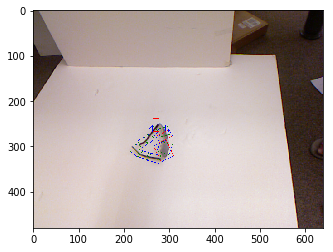

In [20]:
dessiner_labels(r'C:\Users\Admin\Desktop\PJT\Jupyter\Dataset\pcd0155cneg.txt',r'C:\Users\Admin\Desktop\PJT\Jupyter\Dataset\pcd0155cpos.txt',r'C:\Users\Admin\Desktop\PJT\Jupyter\Dataset\pcd0155r.png')

287.0
293.046
-8.666666666666666
26.1725046566
51.341060215


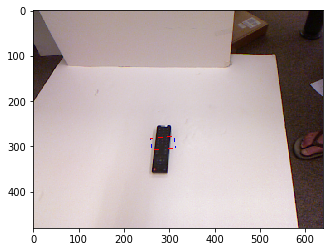

[ 311.001334    277.10353838]
[ 314.001334    303.10353838]
[ 262.998666    308.98846162]
[ 259.998666    282.98846162]


In [16]:
im_test= Image.open('pcd0100r.png')
pos=process_graspbox('pcd0100cpos.txt')
x,y,tan_theta,height,width=rectangle_to_grasp(process_rectangles(pos),2)
print(x)
print(y)
print(tan_theta)
print(width)
print(height)
a,b,c,d=dessiner_rectangle_apartir_grasp(x,y,tan_theta,height,width,im_test)
print(a)
print(b)
print(c)
print(d)

#### Crop de l'image

Les images semblent à peu près centrés sur les objets. Pour réduire les dimensions du problème, il peut être intéressant de rogner de 50% les images.

In [16]:
def crop_center(img,cropx,cropy):
    y,x,color = np.shape(img)
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [17]:
def crop_image(img_filename,cropx,cropy):
    image_test = load_image(img_filename)
    image_cropped = crop_center(image_test,320,240)
    image_affichee=Image.fromarray(np.uint8(image_cropped))
    image_affichee.save(img_filename[:-4] +'_cropped.png', "PNG")
    return

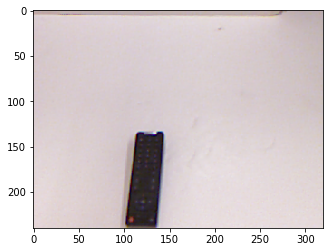

In [18]:
crop_image('pcd0100r.png',320,240)
image1=Image.open('pcd0100r_cropped.png')
plt.imshow(image1)
plt.show()

Il faut alors adapter les labels (retrancher les pixels)

In [19]:
def crop_labels(filename, cropx, cropy):
    listepoints = np.array(process_graspbox(filename))
    listepoints[::2]-=cropx/2
    listepoints[1::2]-=cropy/2
    file_cropped=open(filename[:-4] + '_cropped.txt','w')
    for i in range(len(listepoints)):
        if i%2 == 0:
            file_cropped.write(str(listepoints[i])+' '+str(listepoints[i+1])+"\n")
    file_cropped.close()
    return

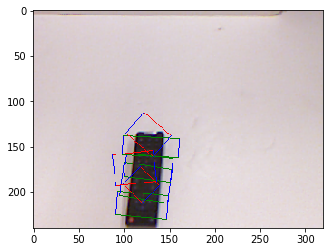

In [20]:
crop_labels('pcd0100cneg.txt',320,240)
crop_labels('pcd0100cpos.txt',320,240)
dessiner_labels('pcd0100cneg_cropped.txt','pcd0100cpos_cropped.txt','pcd0100r_cropped.png')

On retrouve l'ensemble des rectangles labelisés pour cet objet-ci. Reste à voir si cela foncionne pour l'ensemble de la position. Cela dépend uniquement de la position des objets relativement au centre de l'image.

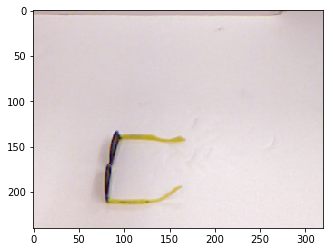

In [22]:
crop_image('pcd0134r.png',320,240)
image1=Image.open('pcd0134r_cropped.png')
plt.imshow(image1)
plt.show()

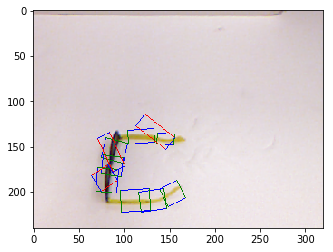

In [23]:
crop_labels('pcd0134cneg.txt',320,240)
crop_labels('pcd0134cpos.txt',320,240)
dessiner_labels('pcd0134cneg_cropped.txt','pcd0134cpos_cropped.txt','pcd0134r_cropped.png')